# <font size="20"> <center> Hirsch Index Prediction
<center> <font size="4"> Matan Kichler and Oz Diamond  
    
<center> <font size="4"> Holon Institue of Technology
    
<center> <font size="4"> Data Science Course • Semester A • 17.02.2023

Link to slides: https://docs.google.com/presentation/d/18zYlCrpLaY4L8KOhPoaFUWYUXElDvRmQ9fWBs7C8yEM/edit?usp=sharing

# Table of Contents
* [Abstract](#abstract)
* [Imports](#imports)
* [Data Scraping](#scrapingthedata)
    * [Web crawling](#webcrawling)
    * [API requests](#apirequests)
* [Data cleansing](#datacleansing)
    * [Removing corrupted wrong rows](#Removingunexpectedwrongrows)
    * [Determine the gender and removing undetermined gender rows](#Determiningthegender)
    * [Removing non scientists rows](#nonscientists)
    * [Removing duplications](#Removingduplications)
    * [Dealing with ouliers](#Dealingwithouliers)
* [Exploratory Data Analysis](#ExploratoryDataAnalysis)
    * [Words cloud](#wordscloud)
    * [Scatter plots](#Scatterplots)
    * Features related to gaps and biases upon the h index
        * [Nation](#Nationalbiases)
        * [institute's prestige](#institutesprestigebiases)
        * [Gender](#gender)
    * [Interim conclusions](#Interimconclusions)
* [Machine learning models](#Machinelearningmodels)
    * [Preparations](#Preparations)
    * Different machine learning algorithms
        * [Linear Regression](#LinearRegression)
            * [Improving attempts](#Improvingattempts)
        * [Random Forest](#RandomForest)
    * [Demonstration](#Demonstration)
* [Conclusions](#Conclusions)

# <a class="anchor" id="abstract"></a> <span style="color:black"> Abstract </span> 
>_*"The <a class="anchor" href="https://en.wikipedia.org/wiki/H-index">h-index</a> is an author-level metric that measures both the productivity and citation impact of the publications, initially used for an individual scientist or scholar. The h-index correlates with obvious success indicators such as winning the Nobel Prize, being accepted for research fellowships and holding positions at top universities."*_  
~Wikipedia 

### Calculation method of the h index
The h-index is the largest number h such that h articles have at least h citations each. For example, if an author has five publications, with 9, 7, 6, 2, and 1 citations (ordered from greatest to least), then the author's h-index is 3, because the author has three publications with 3 or more citations. However, the author does not have four publications with 4 or more citations. 

### The research assumption
Our assumption is that the h-index could be predicted without any formulas or some sort of calculations. We assume that if given information about scientists; their degree or position, their gender, the institues in which they are active from and ect - we could predict their h-index as well with the using of some basic machine learning algorithms.

* Even if the prediction would not be as optimal as we expect (i.e. bad fitting), the model itself could be a worthy candidate of an alternative scientist success prediction model, and should be named after both students Matan and Oz.

* We will discuss which of the ML models have a better accuracy in its predictions

# <a class="anchor" id="imports"></a> <span style="color:black"> Imports </span> 

In [2]:
import pandas as pd
import numpy as np
import os
import json
import time
import random
import warnings
warnings.filterwarnings('ignore')

# web crawling
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.window import WindowTypes

# API requests
import requests as rq
from bs4 import BeautifulSoup as bs

# ploting graph
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import Counter

# machine learning algorithms
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# visualizing data in words' cloud
import stylecloud
from IPython.display import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


%matplotlib inline

# <a class="anchor" id="scrapingthedata"></a> <span style="color:black"> Data Scraping </span> 
>_*"Data scraping used for extracting data from websites. Web scraping software may directly access the World Wide Web using the Hypertext Transfer Protocol or a web browser. While web scraping can be done manually by a software user, the term typically refers to automated processes implemented using a bot or web crawler. "*_  
~Wikipedia  

We use both crawling and API. the crawling itself took us about 3 days of gathering data with bots.

### Login to ResearchGate
ResearchGate is a European commercial social networking site for scientists and researchers to share papers, ask and answer questions, and find collaborators. The biggest of its kind. Its data should be trusted.

In [ ]:
driver = webdriver.Firefox()
driver.get("https://www.researchgate.net/login")

password = driver.find_element(By.ID, "input-password")
username = driver.find_element(By.ID, "input-login")

password.send_keys("kcaeDHT8uE5wYMe")
username.send_keys("matanki@my.hit.ac.il")
password.send_keys(Keys.RETURN)

### Columns of the data-frame

In [ ]:
fullname = []
gender = []
position = []
nation = []
institute = []
shanghai_ranking = []
depratment = []
disciplines = []
publications = []
citations = []
recommendations = []
top_cited_research = []
interest_score = []
reads = []
h_index = []
URL = []

### Lists of institutes around the world
* *instLst_1* - Israeli universities and collages
* *instLst_2* - Ivy League universities - Eight private research universities in the Northeastern United States.
* *instLst_3* - Top internationally universities
* *instLst_4* - internationally universities
* *instLst_5* - Latin america universities

In [ ]:
instLst_1 = ["Holon-Institute-of-Technology", "Tel Aviv University",
           "Hebrew University of Jerusalem", "Bar Ilan University",
           "Technion-Israel Institute of Technology", "The-Open-University-of-Israel",
           "Ben-Gurion-University-of-the-Negev", "Ariel-University",
           "University-of-Haifa", "Weizmann-Institute-of-Science",
           "Academic College of Tel Aviv-Yafo", "Shamoon-College-of-Engineering"]

instLst_2 = ["Brown University", "Harvard University",
           "Yale-University", "University of Pennsylvania",
           "Columbia-University", "Geisel-School-of-Medicine",
           "Princeton University", "Cornell University"]

instLst_3 = ["Stanford-University", "Massachusetts-Institute-of-Technology",
            "University of Cambridge", "University-of-California-Berkeley",
            "University-of-Oxford", "Universite_Paris-Saclay",
            "Ecole-Polytechnique", "ETH-Zurich", "University-of-Toronto",
            "The University of Tokyo", "Tsinghua University"]

instLst_4 = ["Ege-University", "Hallym-University",
            "University of Iceland", "University of Delhi",
            "University of Cyprus", "Umea-University",
            "Tampere-University", "Tehran University of Medical Sciences",
            "University-of-Malaya", "Universita degli Studi di Milano-Bicocca",
            "University-of-Granada"]

instLst_5 = ["Pontificia Universidad Católica de Chile", "Universidade de São Paulo",
            "Instituto Tecnológico y de Estudios Superiores de Monterrey",
            "Universidad de los Andes", "Universidade Estadual de Campinas",
            "Universidad Nacional Autónoma de Mexico", "Universidad de Chile",
            "Universidad de Buenos Aires", "Universidade Federal do Rio de Janeiro",
            "Universidad Nacional de Colombia", "UNESP", "Universidad de Concepción",
            "Universidad de Santiago de Chile (USACH)", "Universidad de Antioquia",
            "Pontificia Universidade Católica do Rio de Janeiro", "Pontificia Universidad Javeriana",
            "Universidade Federal de Minas Gerais", "Pontificia Universidad Católica del Peru",
            "Rica Universidad de Costa Rica", "Universidade Federal Rio Grande do Sul"]

### Shanghai ranking & Nations dict.

In [ ]:
# dictionary
inst_rank = {
    "Holon-Institute-of-Technology":801,
    "Tel Aviv University":151,
    "Hebrew University of Jerusalem":77,
    "Bar Ilan University":301,
    "Technion-Israel Institute of Technology":83,
    "The-Open-University-of-Israel":201,
    "Ben-Gurion-University-of-the-Negev":401,
    "Ariel-University":801,
    "University-of-Haifa":501,
    "Weizmann-Institute-of-Science":83,
    "Academic College of Tel Aviv-Yafo":801,
    "Shamoon-College-of-Engineering":801,
    "Brown University":47,
    "Harvard University":1,
    "Yale-University":11,
    "University of Pennsylvania":15,
    "Columbia-University":8,
    "Geisel-School-of-Medicine":301,
    "Princeton University":6,
    "Cornell University":12,
    "Stanford-University":2,
    "Massachusetts-Institute-of-Technology":3,
    "University of Cambridge":4,
    "University-of-California-Berkeley":5,
    "University-of-Oxford":7,
    "Universite_Paris-Saclay":16,
    "Ecole-Polytechnique":301,
    "ETH-Zurich":20,
    "University-of-Toronto":22,
    "The University of Tokyo":24,
    "Tsinghua University":26,
    "Ege-University":901,
    "Hallym-University":901,
    "University of Iceland":601,
    "University of Delhi":601,
    "University of Cyprus":501,
    "Umea-University":501,
    "Tampere-University":401,
    "Tehran University of Medical Sciences":401,
    "University-of-Malaya":301,
    "Universita degli Studi di Milano-Bicocca":301,
    "University-of-Granada":201,
    'Pontificia_Universidad_Catolica_de_Chile' : 500 , 
    'University-of-Sao-Paulo':101 ,
    'Los-Andes-University-Colombia':101 ,
    'University_of_Campinas':150 ,
    'Universidad_Nacional_Autonoma_de_Mexico' : 405 ,
    'University-of-Chile': 401 , 
    'Universidad_de_Buenos_Aires' :67  , 
    'Federal-University-of-Rio-de-Janeiro2' : 401 ,
    'National_University_of_Colombia' : 801,
    'Sao_Paulo_State_University' : 801 ,
    'Universidad_de_Concepcion':801 ,
    'University-of-Santiago-Chile' : 401
}
    

inst_nation = {
    "Holon-Institute-of-Technology":"Israel",
    "Tel Aviv University":"Israel",
    "Hebrew University of Jerusalem":"Israel",
    "Bar Ilan University":"Israel",
    "Technion-Israel Institute of Technology":"Israel",
    "The-Open-University-of-Israel":"Israel",
    "Ben-Gurion-University-of-the-Negev":"Israel",
    "Ariel-University":"Israel",
    "University-of-Haifa":"Israel",
    "Weizmann-Institute-of-Science":"Israel",
    "Academic College of Tel Aviv-Yafo":"Israel",
    "Shamoon-College-of-Engineering":"Israel",
    "Brown University":"United States",
    "Harvard University":"United States",
    "Yale-University":"United States",
    "University of Pennsylvania":"United States",
    "Columbia-University":"United States",
    "Geisel-School-of-Medicine":"United States",
    "Princeton University":"United States",
    "Cornell University":"United States",
    "Stanford-University":"United States",
    "Massachusetts-Institute-of-Technology":"United States",
    "University of Cambridge":"Great Britain",
    "University-of-California-Berkeley":"United States",
    "University-of-Oxford":"Great Britain",
    "Universite_Paris-Saclay":"France",
    "Ecole-Polytechnique":"France",
    "ETH-Zurich":"Switzerland",
    "University-of-Toronto":"Canada",
    "The University of Tokyo":"Japan",
    "Tsinghua University":"Chaina",
    "Ege-University":"Turkey",
    "Hallym-University":"South Korea",
    "University of Iceland":"Iceland",
    "University of Delhi":"India",
    "University of Cyprus":"Cyprus",
    "Umea-University":"Sweden",
    "Tampere-University":"Finland",
    "Tehran University of Medical Sciences":"Iran",
    "University-of-Malaya":"Malaysia",
    "Universita degli Studi di Milano-Bicocca":"Italy",
    "University-of-Granada":"Spain"
    'Pontificia_Universidad_Catolica_de_Chile' : "Chile" , 
    'University-of-Sao-Paulo' : "Brazil" ,
    'Los-Andes-University-Colombia':"Colombia" ,
    'University_of_Campinas': "Brazil" ,
    'Universidad_Nacional_Autonoma_de_Mexico' : "Mexico" ,
    'University-of-Chile': "Chile" , 
    'Universidad_de_Buenos_Aires' : "Argentina"  , 
    'Federal-University-of-Rio-de-Janeiro2' : "Brazil",
    'National_University_of_Colombia' : "Colombia",
    'Sao_Paulo_State_University' : "Brazil",
    'Universidad_de_Concepcion':"Chile" ,
    'University-of-Santiago-Chile' : "Chile"
}

## <a class="anchor" id="apirequests"></a> <span style="color:black"> API requests </span> 
### Determine the gender

In [ ]:
def genderFromName(string):
    name = string.split()
    name = name[0]
#     print(name) # taking only firstname
    url = "https://api.genderize.io?name="+name
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:102.0) Gecko/20100101 Firefox/102.0'}
    file = rq.get(url, headers=headers)
    if str(file.content).find("female") == -1: #TODO: maybe a better way in time consuming.
        return "male"
    else:
        return "female"

## <a class="anchor" id="webcrawling"></a> <span style="color:black"> Web crawling </span> 
### Gathering information from ResearchGate

In [ ]:
def crawler(instLst, NumOfSientistPerInstatue):
    for x in instLst:
        driver.get("https://www.researchgate.net/institution/"+x+"/members")
        content = driver.find_element(By.XPATH, '/html/body/div[1]/div[3]/div[1]/div/div/div[2]/div/div[1]/div/div[3]/div/div/nav/div[7]/a/span')
        index = bs(content.get_property("innerHTML"), "html.parser").get_text()
    #     print(index) # Number of member pages for each institue

        limit = min(int(index) + 1, NumOfSientistPerInstatue + 1) # we don't mind more than 100*10 researchers per institue

        for i in range(1, limit): #int(index) + 1

            driver.get("https://www.researchgate.net/institution/"+x+"/members/"+str(i))
            p = driver.current_window_handle

            for j in range(1, 11):

                try:
                    name = driver.find_element(By.XPATH, "/html/body/div[1]/div[3]/div[1]/div/div/div[2]/div/div[1]/div/div[2]/div/div["+str(j)+"]/div/div/div[2]/div/div[1]/div/div/h5/a")
                    url = name.get_attribute('href')
                    name = bs(name.get_property("innerHTML"), "html.parser").get_text()
                    print(url)
                    print(name)
                except:
                    break #no more people to show

                try:
                    Gender = genderFromName(name)
                except:
                    Gender = "Nan"

                print (Gender)
                print(x)
                print(inst_rank[x])
                try:
                    Department = driver.find_element(By.XPATH, "/html/body/div[1]/div[3]/div[1]/div/div/div[2]/div/div[1]/div/div[2]/div/div["+str(j)+"]/div/div/div[2]/div/div[2]/div/div[2]/ul/li/span")
                    Department = bs(Department.get_property("innerHTML"), "html.parser").get_text()
                    print(Department)
                except:
                    Department = "Nan"
                    print("Nan")

                try: 
                    Disciplines = driver.find_element(By.XPATH, "/html/body/div[1]/div[3]/div[1]/div/div/div[2]/div/div[1]/div/div[2]/div/div["+str(j)+"]/div/div/div[2]/div/div[3]/div/div[2]")
                    Disciplines = bs(Disciplines.get_property("innerHTML"), "html.parser").get_text("|", strip=True)
    #                 A = [text for text in disciplines.stripped_strings] # getting list of disciplines instead of on string
                    print(Disciplines)
                except:
                    Disciplines = "Nan"
                    print("Nan")

                # all data on the members' page was collected    
                # now we want to reach the web page of the sientist

                driver.switch_to.new_window(WindowTypes.TAB)
                driver.get(url+'/stats')

                try: 
                    Research_Interest_Score = driver.find_element(By.XPATH, "/html/body/div[1]/div[3]/div[1]/div/div/div/div[2]/div[1]/div/div/div[1]/div/div/div/div[2]/ul/li[1]/div/div/div/div[1]/div")
                    Research_Interest_Score = bs(Research_Interest_Score.get_property("innerHTML"), "html.parser").get_text()
                    if Research_Interest_Score == '- -':
                        Research_Interest_Score = "0";
                    print(Research_Interest_Score)
                except:
                    Research_Interest_Score = "0"
                    print("Nan")

                try: 
                    Reads = driver.find_element(By.XPATH, "/html/body/div[1]/div[3]/div[1]/div/div/div/div[2]/div[1]/div/div/div[1]/div/div/div/div[2]/ul/li[2]/div/div/div/div[1]/div")
                    Reads = bs(Reads.get_property("innerHTML"), "html.parser").get_text()
                    print(Reads)
                except:
                    Reads = "0"
                    print("Nan")

                try: 
                    Citations = driver.find_element(By.XPATH, "/html/body/div[1]/div[3]/div[1]/div/div/div/div[2]/div[1]/div/div/div[1]/div/div/div/div[2]/ul/li[3]/div/div/div/div[1]/div")
                    Citations = bs(Citations.get_property("innerHTML"), "html.parser").get_text()
                    print(Citations)
                except:
                    Citations = "0"
                    print("Nan")

                try: 
                    Recommendations = driver.find_element(By.XPATH, "/html/body/div[1]/div[3]/div[1]/div/div/div/div[2]/div[1]/div/div/div[1]/div/div/div/div[2]/ul/li[4]/div/div/div/div[1]/div")
                    Recommendations = bs(Recommendations.get_property("innerHTML"), "html.parser").get_text()
                    print(Recommendations)
                except:
                    Recommendations = "0"
                    print("Nan")

                try: 
                    hindex = driver.find_element(By.XPATH, "/html/body/div[1]/div[3]/div[1]/div/div/div/div[2]/div[1]/div/div/div[3]/div/div/div/div[2]/ul/li[1]/ul/li[1]/div/div/div/div[1]/div")
                    hindex = bs(hindex.get_property("innerHTML"), "html.parser").get_text()
                    print(hindex)
                except:
                    hindex = "0"
                    print("Nan")

                try: 
                    Top_cited_research = driver.find_element(By.XPATH, "/html/body/div[1]/div[3]/div[1]/div/div/div/div[2]/div[1]/div/div/div[3]/div/div/div/div[2]/ul/li[2]/div/div/div/div[2]/div/a/strong")
                    Top_cited_research = bs(Top_cited_research.get_property("innerHTML"), "html.parser").get_text()
                    print(Top_cited_research)
                except:
                    Top_cited_research = "Nan"
                    print("Nan")

                try: 
                    Position = driver.find_element(By.XPATH, "/html/body/div[1]/div[3]/div[1]/div/div/div/div[1]/div[1]/div[1]/div/div/div[2]/div/div[3]/ul/li[1]")
                    Position = bs(Position.get_property("innerHTML"), "html.parser").get_text()
                    word = Position.split()[0]
                    if word == x.split()[0] or word == x.split('-')[0]:
                        Position = "Nan"
                    print(Position)
                except:
                    Position = "Nan"
                    print("Nan")

                try: 
                    no_publications = driver.find_element(By.XPATH, '/html/body/div[1]/div[3]/div[1]/div/div/div/div[1]/div[2]/div/div/div/div[1]/div/nav/div/div[1]/a[2]/div/div')
                    no_publications = bs(no_publications.get_property("innerHTML"), "html.parser").get_text()

                    # reciving the number of publications

                    no_publications = no_publications.split()[1].strip('()')
                    print(no_publications)

                except:
                    no_publications = "0"
                    print("0")


                # now we've done scraping all relevent data on this sientinst
                # we close the tab and return to previous tab

                time.sleep(random.uniform(1.9, 2.4)) # In order to react less suspicious
                driver.close()
                driver.switch_to.window(p)

                print("\n")

                fullname.append(name)
                gender.append(Gender)
                position.append(Position)
                nation.append(inst_nation[x])
                institute.append(x)
                shanghai_ranking.append(inst_rank[x])
                depratment.append(Department)
                disciplines.append(Disciplines)
                publications.append(float(no_publications.replace(",", "").replace(".", "")))
                citations.append(float(Citations.replace(",", "").replace(".", "")))
                recommendations.append(float(Recommendations.replace(",", "").replace(".", "")))
                top_cited_research.append(Top_cited_research)
                # top_cited_research_journal +=
                interest_score.append(float(Research_Interest_Score.replace(",", "").replace(".", "")))
                reads.append(float(Reads.replace(",", "").replace(".", "")))
                h_index.append(float(hindex.replace(",", "").replace(".", "")))
                URL.append(url)


In [ ]:
crawler(instLst_1, 100)
crawler(instLst_2, 100)
crawler(instLst_3, 100)
crawler(instLst_4, 100)
crawler(instLst_5, 100)

In [ ]:
df = pd.DataFrame({"Full name":fullname, "Gender":gender, "Position":position,
                   "Nation":nation, "Institute":institute, "Shanghai_ranking":shanghai_ranking,
                   "Depratment":depratment, "Disciplines":disciplines, "Publications":publications,
                   "Citations":citations, "Recommendations":recommendations,
                   "Top cited research":top_cited_research, "Interest score":interest_score, 
                   "Reads":reads, "h index":h_index, "URL":URL})

df.to_csv('sientinst_data')

In [ ]:
df

# <a class="anchor" id="datacleansing"></a> <span style="color:black"> Data cleansing </span>
>_*"the process of detecting and correcting (or removing) corrupt or inaccurate records from a record set, table, or database and refers to identifying incomplete, incorrect, inaccurate or irrelevant parts of the data and then replacing, modifying, or deleting the dirty or coarse data"*_  
~Wikipedia  

Some rows had more than 15 columns, which happend to be a mistake

Data to clean 
* people that do not conduct research 
* people we couldnt find their gender

Columns to edit 
* Position --change to scale from 0 to 4
    0 No Degree
    1 Bachelors Degree
    2 Maters Degree
    3 Doctor Of Philosophy
    4 Proffesor (Part time or Full)
* Categories for contries (with sk label)

Add columns with statistics of each contry such as 
* Human Development Index
* PISA score - Programme for International Student Assessment 
* GDP - gross domestic product

In [3]:
os.getcwd()

'/home/archie/Projects/h-index-prediction'

In [4]:
def load_dataset(file_name):
    return pd.read_csv(file_name)


In [5]:
df = load_dataset('sientinst_data_merged.csv')

## <a class="anchor" id="Removingunexpectedwrongrows"></a> <span style="color:black"> Removing corruped rows </span> 

In [6]:
def cleansing(df): # Inplace
    len_before = len(df['Reads'])
    df.drop(df[df['Shanghai_ranking'].str.isnumeric() == False].index, inplace = True)
    df.drop(df[df['Publications'].str.isnumeric() == False].index, inplace = True)
    df.drop(df[df['Reads'].str.isnumeric() == False].index, inplace = True)
    df.drop(df[df['Citations'].str.isnumeric() == False].index, inplace = True)
    df.drop(df[df['Interest score'].str.isnumeric() == False].index, inplace = True)
    len_after = len(df['Reads'])
    print(str(len_before-len_after)+" rows were removed")
    df.to_csv('sientist_data_cleansing', index=False)

In [7]:
cleansing(df)
df.head()


975 rows were removed


Full name  Gender  \
0          Thomas Serre    male   
1       Abdullah Chahin    male   
2     Richard M Mariita    male   
3  Sharon Miriam Swartz  female   
4         Roberto Zenit    male   

                                            Position         Nation  \
0                                                PhD  United States   
1                                                 MD  United States   
2  BEd (Science), MSc (Microbiology) both from Ke...  United States   
3                   Ph.D., The University of Chicago  United States   
4                                              Ph.D.  United States   

          Institute Shanghai_ranking  \
0  Brown University               47   
1  Brown University               47   
2  Brown University               47   
3  Brown University               47   
4  Brown University               47   

                                          Depratment  \
0  Department of Cognitive, Linguistic and Psycho...   
1                   Division of Infectious Diseases    
2                            Department of Chemistry   
3     Department of Ecology and Evolutionary Biology   
4                        Brown School of Engineering   

                                         Disciplines Publications Citations  \
0  Machine Vision|Object Recognition|Machine Lear...          183     11905   
1                 Sepsis|ICU|Intensive Care Medicine           62       234   
2                          Microbiology|Genomics|PCR           39       286   
3                       Zoology|Biomechanics|Mammals          152      4510   
4  Numerical Simulation|Fluid Mechanics|Fluid Dyn...          235      3444   

  Recommendations                                 Top cited research  \
0              64  HMDB51: A Large Video Database for Human Motio...   
1               5             False alarm reduction in critical care   
2              55  Antitubercular and Phytochemical Investigation...   
3              45  The 'Law of Bone Transformation': A Case of Cr...   
4             141        Particle-wall collisions in a viscous fluid   

  Interest score  Reads h index  \
0           6087  33978      40   
1           1379   3586       9   
2           1959   4724       7   
3           2329  37724      39   
4           2294  48142      31   

                                                 URL  
0  https://www.researchgate.net/profile/Thomas-Serre  
1  https://www.researchgate.net/profile/Abdullah_...  
2  https://www.researchgate.net/profile/Richard_M...  
3  https://www.researchgate.net/profile/Sharon-Sw...  
4  https://www.researchgate.net/profile/Roberto-Z...

## <a class="anchor" id="Determiningthegender"></a> <span style="color:black"> Determining the gender and removing undetermined gender rows </span> 

to find genders of scientists we use the API / Dataset from Facebook https://github.com/philipperemy/name-dataset
using `pip install name-dataset`

In [8]:
from names_dataset import NameDataset, NameWrapper
nd = NameDataset() # uses 3.2 GB of RAM , use with caution 

In [9]:
def find_gender(name):
    try:
        x = nd.search(name)['first_name']['gender']
        if x['Male'] >= x['Female']:
            return 'Male'
        else:
            return 'Female'
    except: 
        return 'NaN'
first_names = df['Full name'].str.split(' ').apply(lambda x: x[0])
genders_list = list()
for name in first_names:
    genders_list.append(find_gender(name))
df['Gender'] = genders_list

the amount of entries to remove (Gender Not defined)

In [10]:
print(str(len(df[df['Gender']=='NaN']))+" sientists were removed (not determied gender)")

2912 sientists were removed (not determied gender)


In [11]:
df.drop(df[df['Gender'] == "NaN"].index ,inplace = True)
df.to_csv('sientist_data_cleansing_geneder_clear.csv', index=False)

In [12]:
df = load_dataset('sientist_data_cleansing_geneder_clear.csv')

in the following cell we remove all people which apear not being a sientists:
that means they have no publications, reads and ect.

## <a class="anchor" id="nonscientists"></a> <span style="color:black"> Removing non scientists rows </span> 

In [13]:
try:
    df.drop(["Unnamed: 0"], axis=1, inplace=True)
except:
     print ("")

series_to_remove = df[df['Publications'].astype(int) + df['Citations'].astype(int)
                      + df['Recommendations'].astype(int) + df['Interest score'].astype(int)+
                      df['Reads'].astype(int)+ df['h index'].astype(int) == 0].index

print(str(len(series_to_remove))+" sientists were removed (apear to not being sientists)")

df.drop(series_to_remove, inplace = True);


3051 sientists were removed (apear to not being sientists)


## <a class="anchor" id="Removingduplications"></a> <span style="color:black"> Removing duplications </span> 

In [14]:
df.drop_duplicates();

## <a class="anchor" id="Dealingwithouliers"></a> <span style="color:black"> Dealing with ouliers </span> 

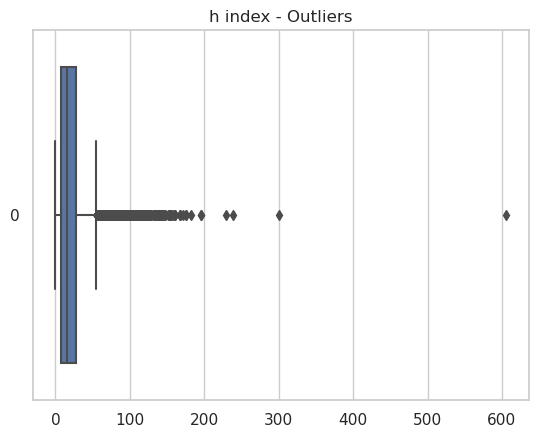

In [15]:
sns.set(style="whitegrid")
sns.boxplot(df["h index"], orient="h");
plt.title("h index - Outliers");

In [16]:
df[df["h index"]>600]

Full name  Gender Position  Nation  \
9265  Cynthia Edenburg  Female      PhD  Israel   

                          Institute  Shanghai_ranking  \
9265  The-Open-University-of-Israel               201   

                                             Depratment  \
9265  Department of History, Philosophy and Judaic S...   

                                        Disciplines  Publications  Citations  \
9265  Distance Education|Online Learning|E-Learning            19         65   

      Recommendations                                 Top cited research  \
9265                0  How (not) to murder a king: Variations on a th...   

      Interest score  Reads  h index URL  
9265              26    338      606   3

In [17]:
df.drop(df[df["h index"]>600].index, inplace = True)

We've search for Cynthia Edenburg, and it seems that her h index is wrongly calcualtely.
So we decide that she's an outlier

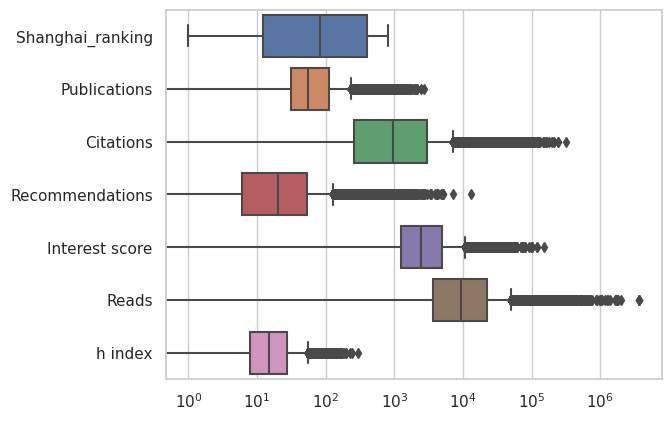

In [18]:
sns.set(style="whitegrid")

# we scale X-axis logaritmically
plt.xscale('log')

sns.boxplot(df, orient="h");

In [19]:
df[df["Reads"]>3500000]

Full name  Gender  \
1705       Goodarz Danaei    Male   
11623  Lital Keinan-Boker  Female   
27472    Regina M Fisberg  Female   

                                          Position         Nation  \
1705   Professor (Associate) at Harvard University  United States   
11623                                 MD, PhD, MPH         Israel   
27472                          Associate Professor         Brazil   

                     Institute  Shanghai_ranking  \
1705        Harvard University                 1   
11623      University-of-Haifa               501   
27472  University-of-Sao-Paulo               101   

                                        Depratment  \
1705   Department of Global Health and Population    
11623                      School of Public Health   
27472          Department of Nutrition (São Paulo)   

                                             Disciplines  Publications  \
1705   Epidemiologic Studies|Hypertension|Epidemiolog...           306   
11623                Cancer|Phytoestrogens|Breast Cancer           297   
27472                  Hypertension|Nutrition|Metabolism           362   

       Citations  Recommendations  \
1705       70185             1306   
11623      25504              759   
27472       6278              429   

                                      Top cited research  Interest score  \
1705   A comparative risk assessment of burden of dis...           35390   
11623  Worldwide trends in body-mass index, underweig...           13242   
27472  Global sodium consumption and death from cardi...            3524   

         Reads  h index                                                URL  
1705   3726175       72  https://www.researchgate.net/profile/Goodarz-D...  
11623  3674694       48  https://www.researchgate.net/profile/Lital-Kei...  
27472  3665645       42                                                NaN

In [20]:
df[df["Recommendations"]>10000]

Full name Gender                                           Position  \
1680  Manu Mangattu   Male  English Professor | Author | NET English Mento...   

             Nation           Institute  Shanghai_ranking  \
1680  United States  Harvard University                 1   

                 Depratment  \
1680  Department of English   

                                            Disciplines  Publications  \
1680  Arts and Humanities|Critical Theory|Literature...           112   

      Citations  Recommendations  \
1680          1            13102   

                                     Top cited research  Interest score  \
1680  Traversing High and Low Culture: Knowledge, We...            3176   

       Reads  h index                                                URL  
1680  693066        1  https://www.researchgate.net/profile/Manu-Mang...

In [21]:
try:
    df.drop(["URL"], axis=1, inplace=True)
except:
     print ("")

we want to add PISA rank & GDP columns:

In [22]:
nation_pisa_science = {"Israel":43, "United States":19, "Great Britain":15, "France":25,
                       "Switzerland":24, "Canada":9, "Japan":6,"China":1,"Turkey":40,
                       "South Korea":8,"Iceland":36,"India":73,"Cyprus":48,"Sweden":20,
                       "Finland":7,"Iran":100,"Malaysia":48,"Italy":40,"Spain":31,"Chile":59,
                       "Brazil":65 ,"Colombia":63,"Mexico":58,"Argentina":65}

nation_GDP = {"Israel":488527, "United States":23315081, "Great Britain":3131378
                      ,"France":2957880 , "Switzerland":800640 , "Canada":1988336
                      ,"Japan":4940878 ,"China":17734063 ,"Turkey":819035
                      ,"South Korea":419015 ,"Iceland":25602 ,"India":3176295
                      ,"Cyprus":28408 ,"Sweden":635664 , "Finland":297302
                      ,"Iran":359713 ,"Malaysia":372981 ,"Italy":2107703
                      ,"Spain":1427381 ,"Chile": 317059 ,"Brazil":1608981
                      ,"Colombia":314464 ,"Mexico":1272839 ,"Argentina":487227}

nation_HDI_score = {"Israel":0.919, "United States":0.921, "Great Britain":0.929, 
                    "France":0.903, "Switzerland":0.962, "Canada":0.936, "Japan":0.925,
                    "China":0.768,"Turkey":0.838,"South Korea":0.925,"Iceland":0.959,
                    "India":0.633,"Cyprus":0.896,"Sweden":0.947,"Finland":0.940,
                    "Iran":0.774,"Malaysia":0.803,"Italy":0.895,"Spain":0.905,
                    "Chile":0.855,"Brazil":0.754 ,"Colombia":0.752,"Mexico":0.758,
                    "Argentina":0.842}

def country_to_pisa_rank(country):
    pisa = []
    for x in country:
        pisa.append(nation_pisa_science[x])
    return pisa

def country_to_GDP(country):
    GDP = []
    for x in country:
        GDP.append(nation_GDP[x])
    return GDP

def country_to_HDI(country):
    HDI = []
    for x in country:
        HDI.append(nation_HDI_score[x])
    return HDI

df['PISA rank'] = country_to_pisa_rank(df['Nation'])
df['GDP (Millions $)'] = country_to_GDP(df['Nation'])
df['HDI score'] = country_to_HDI(df['Nation'])
df.head(2)

Full name Gender Position         Nation         Institute  \
0     Thomas Serre   Male      PhD  United States  Brown University   
1  Abdullah Chahin   Male       MD  United States  Brown University   

   Shanghai_ranking                                         Depratment  \
0                47  Department of Cognitive, Linguistic and Psycho...   
1                47                   Division of Infectious Diseases    

                                         Disciplines  Publications  Citations  \
0  Machine Vision|Object Recognition|Machine Lear...           183      11905   
1                 Sepsis|ICU|Intensive Care Medicine            62        234   

   Recommendations                                 Top cited research  \
0               64  HMDB51: A Large Video Database for Human Motio...   
1                5             False alarm reduction in critical care   

   Interest score  Reads  h index  PISA rank  GDP (Millions $)  HDI score  
0            6087  33978       40         19          23315081      0.921  
1            1379   3586        9         19          23315081      0.921

Scaled categorial variables:
* profesor -> 4
* Ph.D -> 3
* Master -> 2
* Bachelor -> 1
* Other / None -> 0

In [23]:
def position_to_rank(position):
    try:
        position = position.replace(",", "").replace(".", "").replace("_", "").replace("-", "")
        position = position.lower()
    except:
        return 0
    
    if position.find("prof") != -1:
        return 4
    elif position.find("ph") != -1 or position.find("doc") != -1 or position.find("ds") != -1:
        return 3
    elif position.find("md") != -1 or position.find("ma") != -1 or position.find("ms") != -1:
        return 2
    elif position.find("ba") != -1 or position.find("bs") != -1 or position.find("be") != -1:
        return 1
    else:
        return 0

# <a class="anchor" id="ExploratoryDataAnalysis"></a> <span style="color:black"> Exploratory Data Analysis </span> 
>_*"An approach of analyzing data sets to summarize their main characteristics,  
often using statistical graphics and other data visualization methods"*_  
~Wikipedia

In this section we will disscuse the corallation between the parameters we had collected between themselves and their impact on the h index:

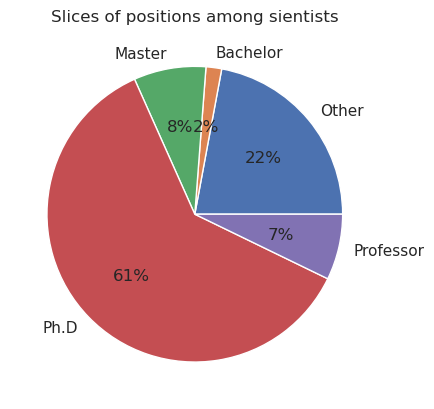

In [24]:
sns.set(style="whitegrid")
edu_rank = []

for pos in df["Position"]:
    val = position_to_rank(pos)
    edu_rank.append(val)

cnt_lst = [edu_rank.count(0), edu_rank.count(1),
          edu_rank.count(2), edu_rank.count(3),
          edu_rank.count(4)]

mylabels = ["Other", "Bachelor", "Master", "Ph.D", "Professor"]

plt.pie(cnt_lst, labels = mylabels, autopct='%1.f%%');
plt.title("Slices of positions among sientists");
# plt.bar(mylabels, cnt_lst);

# adding as an additional column
df['Position rank'] = edu_rank

We see that the majority of the sientists are Ph.D and very few are professors and lower to Ph.D.

We assume that:
* Naturally there are mush less professors than Ph.Ds
* Professors may retired very ofen due to their age, or may be less ambitious than young Ph.Ds
* Professors might be much more buzy in lecturing, pedagogy and other activities rather than in researchs
* Only 2% are Bachelors and it does make sence, because naturally the may countinue to their Master degree or leave the academic enviorment, rather than being involved in researchs
* Many of the Master degrees require a thesis

In [25]:
#Saving the dataset after cleansing to use it in the machine learning section
df_after_data_cleansing = df.copy()

## <a class="anchor" id="wordscloud"></a> <span style="color:black"> Words cloud </span> 

In [26]:
disciplines = df[df['Disciplines'] != "Nan"]['Disciplines'].apply(lambda x:x.split('|'))
L = list()
for entrie in disciplines:
    for item in entrie:
        L.append(item)

text = str()
for item in L: 
    text= text +item +' '

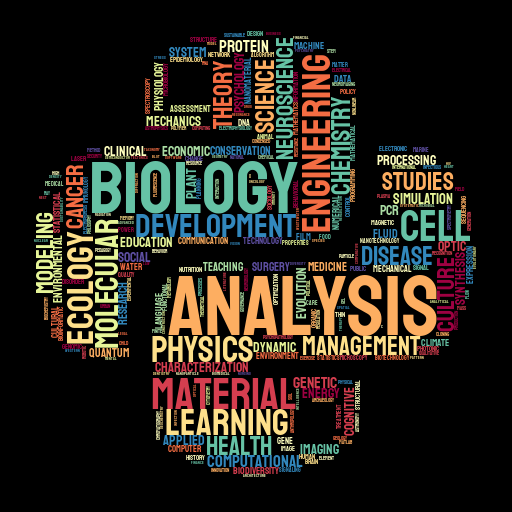

In [27]:
with open('SJ-Speech.txt', 'w') as f:
    f.write(text)

stylecloud.gen_stylecloud(file_path='SJ-Speech.txt',
                          icon_name='fab fa-python',
                          palette='colorbrewer.diverging.Spectral_11',
                          output_name='cloud.png',
                          background_color='black',
                          collocations=False)

Image(filename='cloud.png') 

Disciplines which receive nowadays' most attention, according the the database we had collected.

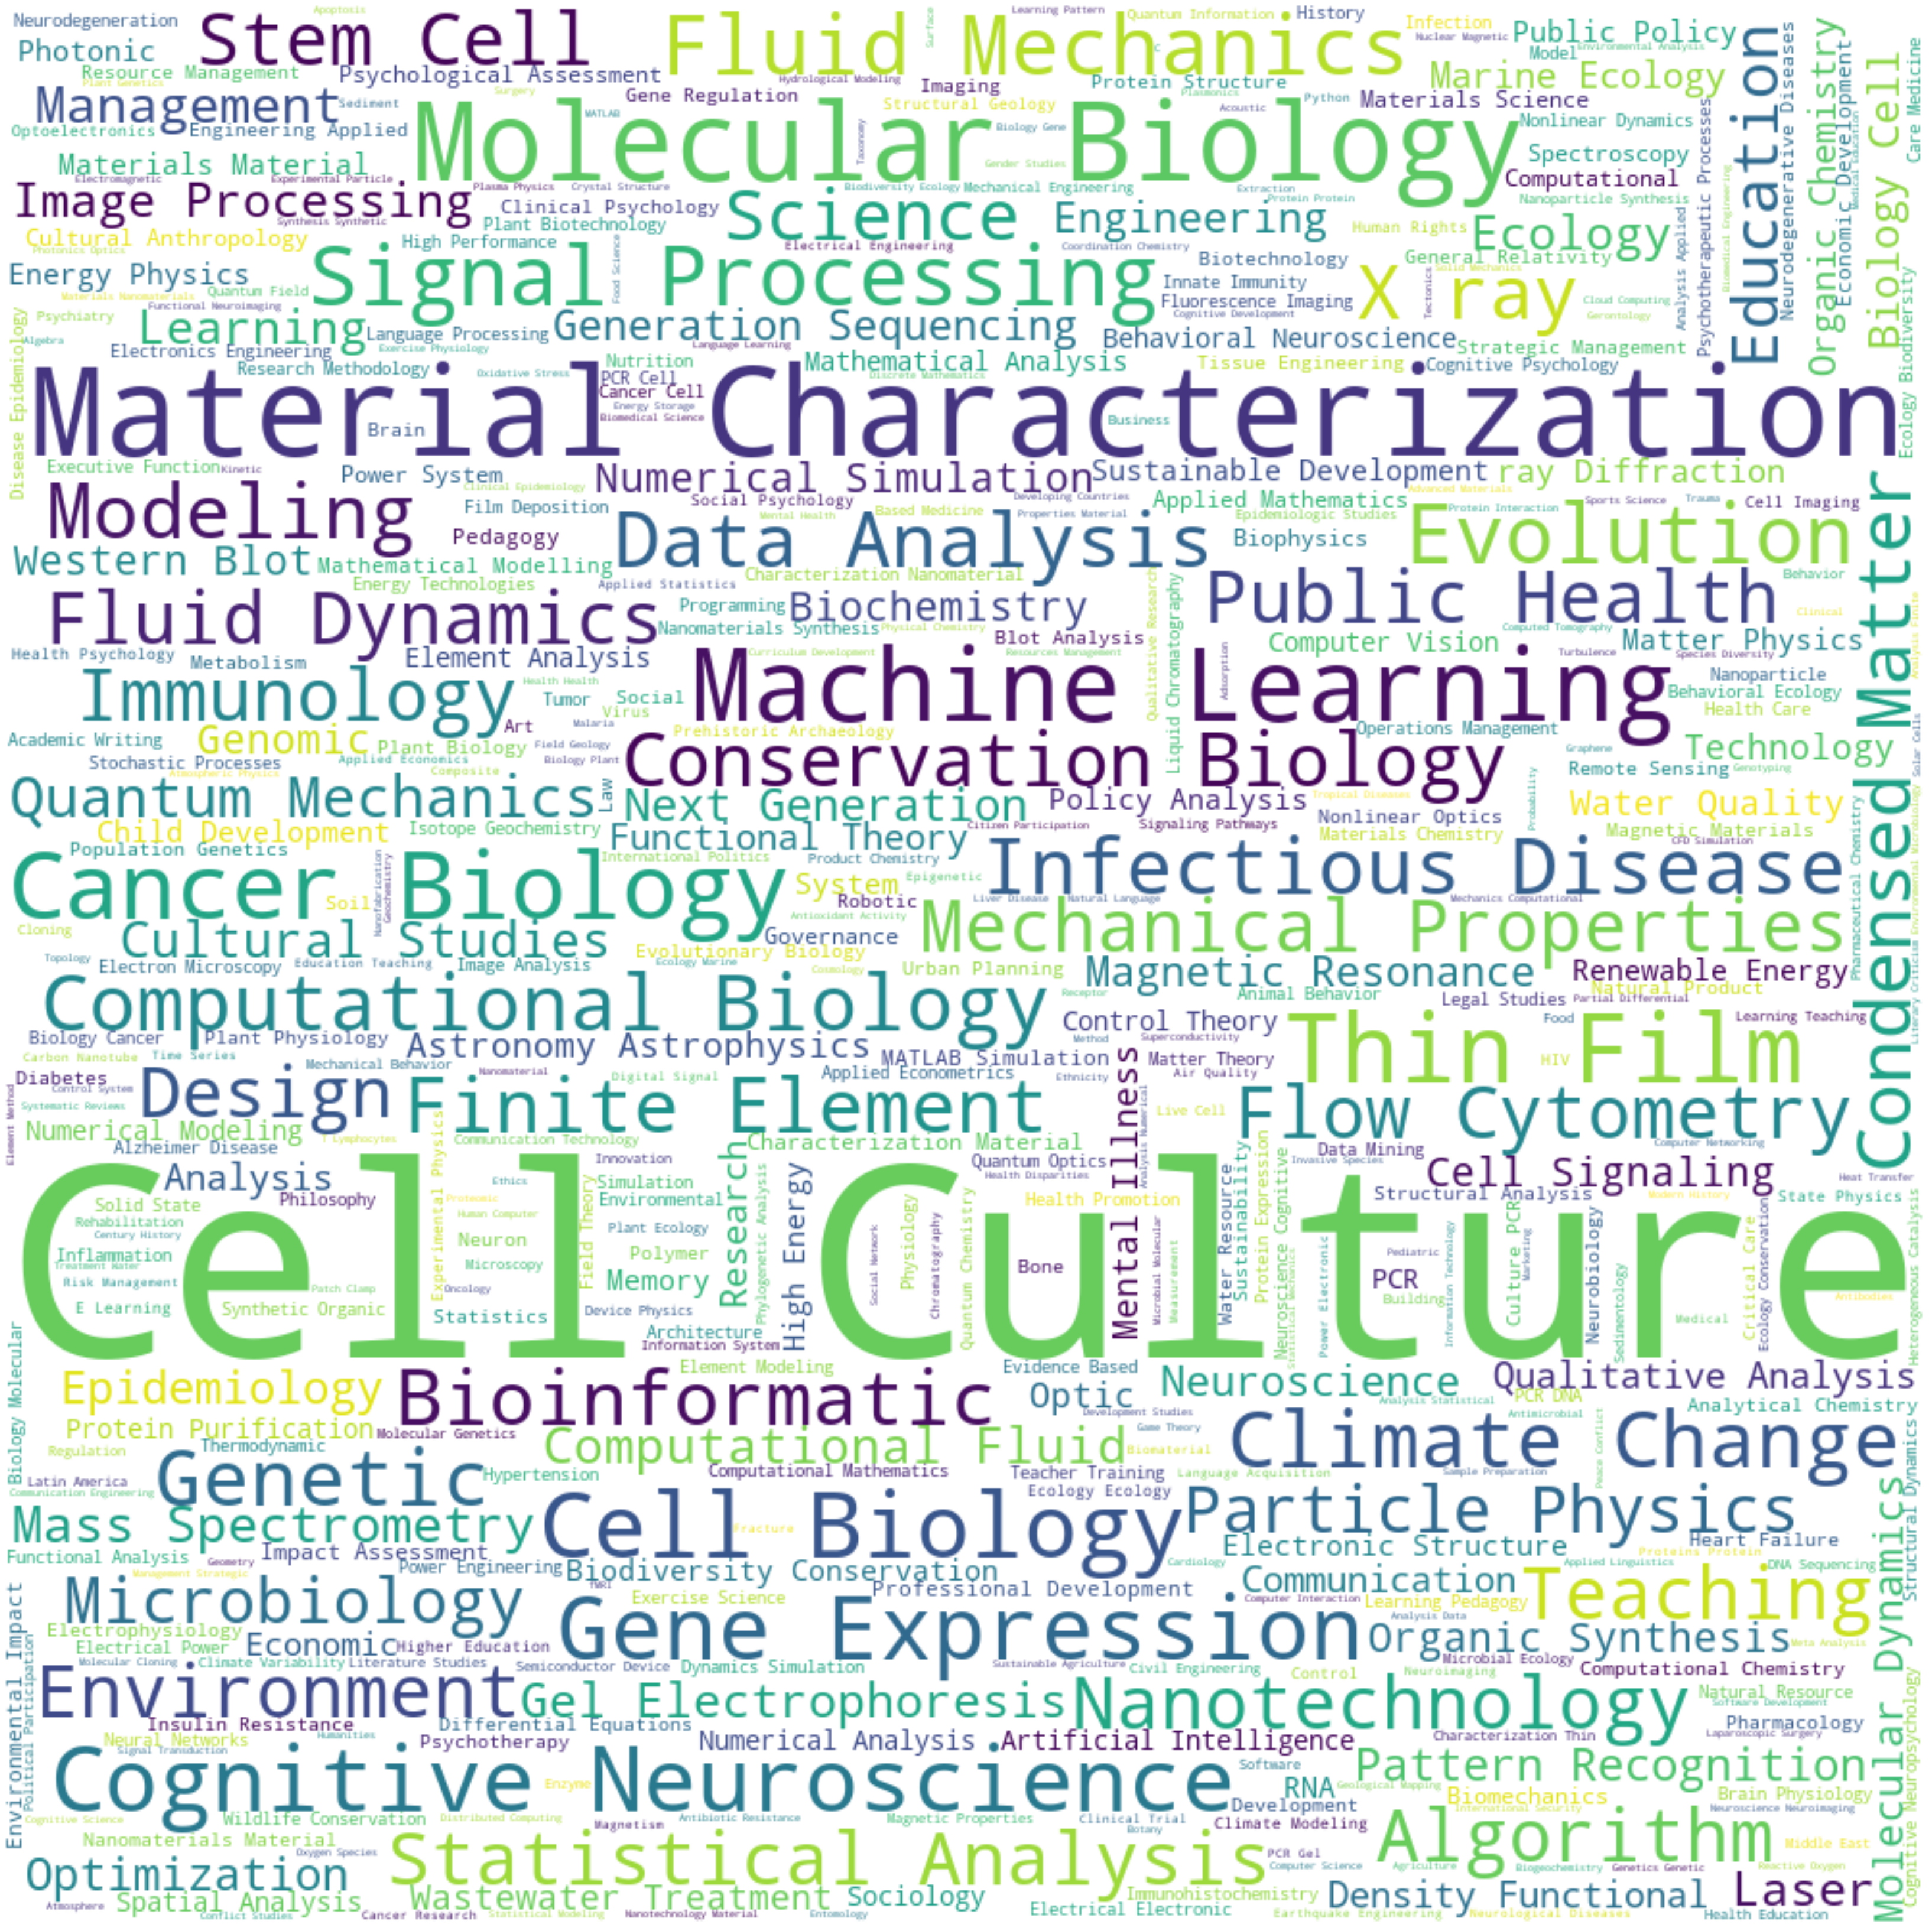

In [28]:
wordcloud = WordCloud(height = 1000, width =1000, max_font_size=200, max_words=500, background_color="white").generate(text)
plt.figure(figsize=(60, 100), dpi=70)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## <a class="anchor" id="Scatterplots"></a> <span style="color:black"> Scatter plots </span> 

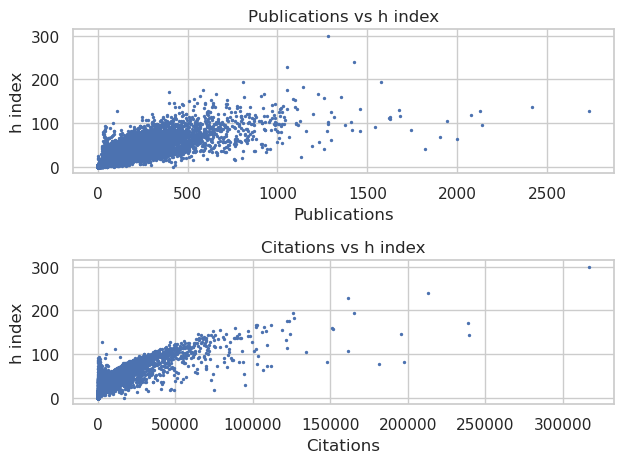

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1)
# fig.suptitle('Correlations to h index')

data={'Publications':df['Publications'].tolist(),
      'h index':df['h index'].tolist()}

tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'Publications', y = 'h index', s = 2, ax=ax1);

data={'Citations':df['Citations'].tolist(),
      'h index':df['h index'].tolist()}
  
tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'Citations', y = 'h index', s = 2, ax=ax2);

ax1.set_title("Publications vs h index");
ax2.set_title("Citations vs h index");
fig.tight_layout()

* We see that some sientists have very high h index altought they published 'few' researchs and their cirations are moderate. That is probably because their very few researchs were very wide-spread.
* very few sientists whom published few researchs recived low h index, which means that is a key requirment for successing as a scientinst.

__we know that citations and publications are the only factor when calculating the h index.  
we want the see ehat is the impact of the other parameters on the h index, and perhaps we could  
invent a better index for perdicting the success of a sientist__

Here is the others correlations:

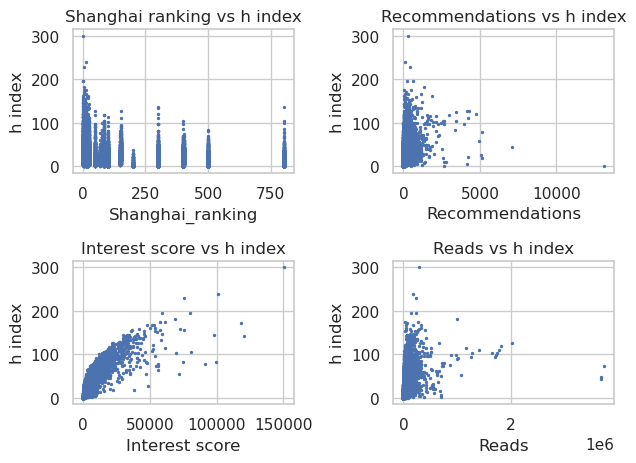

In [30]:
# fig.suptitle('Correlations to h index')

fig, axs = plt.subplots(2, 2)

data={'Shanghai_ranking':df['Shanghai_ranking'].tolist(),
      'h index':df['h index'].tolist()}

tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'Shanghai_ranking', y = 'h index', s = 2, ax=axs[0, 0]);

data={'Recommendations':df['Recommendations'].tolist(),
      'h index':df['h index'].tolist()}
  
tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'Recommendations', y = 'h index', s = 2, ax=axs[0, 1]);

data={'Interest score':df['Interest score'].tolist(),
      'h index':df['h index'].tolist()}

tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'Interest score', y = 'h index', s = 2, ax=axs[1, 0]);

data={'Reads':df['Reads'].tolist(),
      'h index':df['h index'].tolist()}
  
tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'Reads', y = 'h index', s = 2, ax=axs[1, 1]);

axs[0, 0].set_title("Shanghai ranking vs h index");
axs[0, 1].set_title("Recommendations vs h index");
axs[1, 0].set_title("Interest score vs h index");
axs[1, 1].set_title("Reads vs h index");
fig.tight_layout()

###  <a class="anchor" id="Nationalbiases"></a> <span style="color:black"> National analysis </span> 

PISA rank and GDP ranking not giving much information. we would try to find the avarage h index for each nation.  

In [31]:
mini_df = df.groupby(['Nation']).mean()["h index"]

avg_h_index = mini_df.tolist()
nations = ['Argentina', 'Brazil', 'Canada', 'Chile', 'China', 'Colombia', 'France',
          'Great Britain', 'Israel', 'Japan', 'Mexico', 'Switzerland', 'United States']

mini_df = pd.DataFrame({"Nation":nations, "Average h index":avg_h_index})

mini_df['PISA rank'] = country_to_pisa_rank(mini_df['Nation'])
mini_df['GDP (Millions $)'] = country_to_GDP(mini_df['Nation'])
mini_df['HDI score'] = country_to_HDI(mini_df['Nation'])
mini_df.head(1)

Nation  Average h index  PISA rank  GDP (Millions $)  HDI score
0  Argentina        13.673216         65            487227      0.842

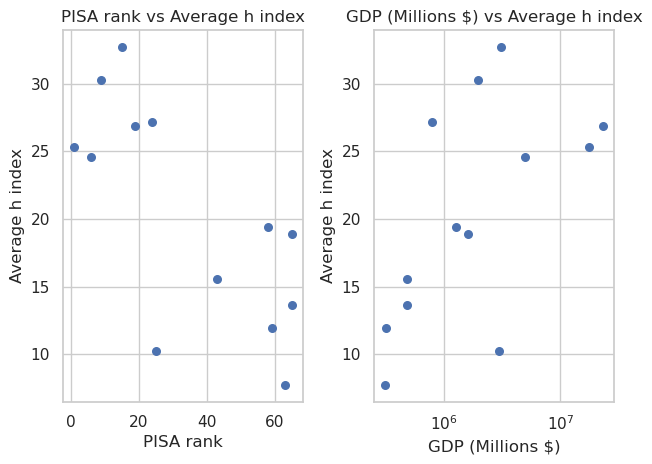

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2)

data={'PISA rank':mini_df['PISA rank'].tolist(),
      'Average h index':mini_df['Average h index'].tolist()}

tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'PISA rank', y = 'Average h index', s = 30, ax=ax1);

data={'GDP (Millions $)':mini_df['GDP (Millions $)'].tolist(),
      'Average h index':mini_df['Average h index'].tolist()}
  
tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'GDP (Millions $)', y = 'Average h index', s = 30, ax=ax2);

ax1.set_title("PISA rank vs Average h index");
ax2.set_title("GDP (Millions $) vs Average h index");
plt.xscale('log')
fig.tight_layout()

### <a class="anchor" id="institutesprestigebiases"></a> <span style="color:black"> HDI and Shanghai ranking </span> 

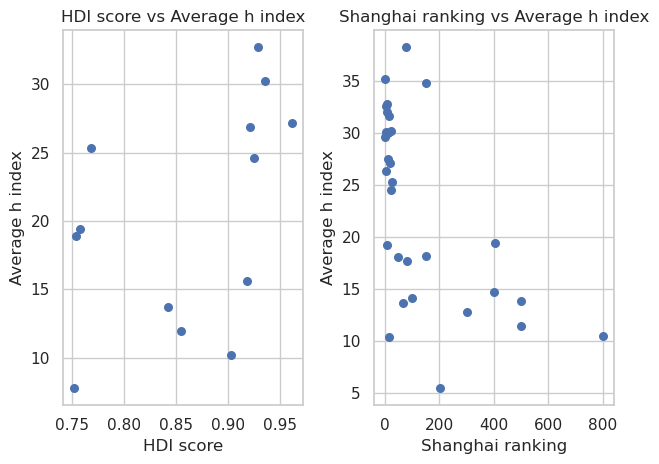

In [33]:
fig, (ax1,ax2) = plt.subplots(1, 2)

data={'HDI score':mini_df['HDI score'].tolist(),
      'Average h index':mini_df['Average h index'].tolist()}
  
tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'HDI score', y = 'Average h index', s = 30, ax=ax1);

ax1.set_title("HDI score vs Average h index");


df_shanghai = df.groupby(['Shanghai_ranking']).mean()["h index"]

Shanghai_ranking = [1,2,3,4,5,6,7,8,11,12,15,16,20,22,24,26,47,67,77,83,101,150,151,201,301,401,405,500,501,801]
lst_avg_per_shanghai = df_shanghai.tolist();

data={'Shanghai ranking':Shanghai_ranking,
      'Average h index':lst_avg_per_shanghai}
  
tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'Shanghai ranking', y = 'Average h index', s = 30, ax=ax2);

ax1.set_title("HDI score vs Average h index");
ax2.set_title("Shanghai ranking vs Average h index");
fig.tight_layout()

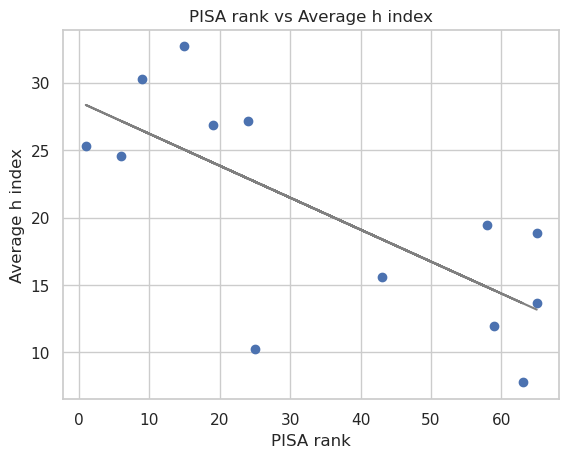

In [34]:
X1 = mini_df[['PISA rank']]
X2 = mini_df[['GDP (Millions $)']]
X3 = mini_df[['HDI score']]
y = mini_df['Average h index']

regressor1 = LinearRegression()
regressor1.fit(X1, y)

regressor2 = LinearRegression()
regressor2.fit(X2, y)

regressor3 = LinearRegression()
regressor3.fit(X3, y)

mini_df2 = pd.DataFrame({"Shanghai ranking":Shanghai_ranking, "Average h index":lst_avg_per_shanghai})
X4 = mini_df2[['Shanghai ranking']]
Y = mini_df2[['Average h index']]

regressor4 = LinearRegression()
regressor4.fit(X4, Y)

plt.scatter(X1, y)
plt.plot(X1, regressor1.predict(X1), color = "grey")

# plt.scatter(X2, y)
# plt.plot(X2, regressor2.predict(X2), color = "grey")
plt.title('PISA rank vs Average h index')
plt.xlabel('PISA rank')
plt.ylabel('Average h index')
plt.show()

In [35]:
print('PISA rank vs Average h index:\n\tR-squared = {:.3f}'.format(r2_score(y, regressor1.predict(X1))))
print('\tPearson correlation coefficient = R = {:.3f}'.format(mini_df.corr()['PISA rank'][0])+'\n')
print('GDP vs Average h index:\n\tR-squared = {:.3f}'.format(r2_score(y, regressor2.predict(X2))))
print('\tPearson correlation coefficient = R = {:.3f}'.format(mini_df.corr()['GDP (Millions $)'][0])+'\n')
print('HDI vs Average h index:\n\tR-squared = {:.3f}'.format(r2_score(y, regressor3.predict(X3))))
print('\tPearson correlation coefficient = R = {:.3f}'.format(mini_df.corr()['HDI score'][0])+'\n')
print('Shanghai ranking vs Average h index:\n\tR-squared = {:.3f}'.format(r2_score(Y, regressor4.predict(X4))))
print('\tPearson correlation coefficient = R = {:.3f}'.format(mini_df2.corr()['Shanghai ranking'][1]))

PISA rank vs Average h index:
	R-squared = 0.524
	Pearson correlation coefficient = R = -0.724

GDP vs Average h index:
	R-squared = 0.157
	Pearson correlation coefficient = R = 0.396

HDI vs Average h index:
	R-squared = 0.213
	Pearson correlation coefficient = R = 0.462

Shanghai ranking vs Average h index:
	R-squared = 0.343
	Pearson correlation coefficient = R = -0.586


* PISA rank of a nations is a good indicator for which country produce better scientists.  
* On the other hand, GDP has low impact, We assume it to be logarithmically (as we scale the x axis logarithmically it seems to have 'linear' correlation)
* We were suprised that the HDI score of a nation have a very little impact on the quality of its scientists

### <a class="anchor" id="gender"></a> <span style="color:black"> gender analysis </span> 

First, we wish to know, whether Male or Female are the majority in each academic positions:

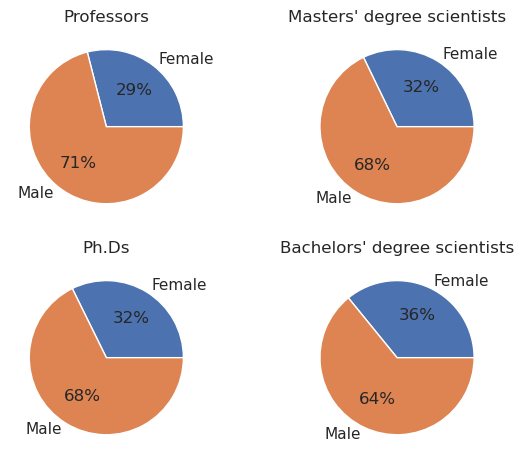

In [36]:
fig, axs = plt.subplots(2, 2)

mylabels = ['Female','Male']

tmp = df[df['Position rank'] == 4]
F_prof = len(tmp[tmp['Gender'] == 'Female'])
M_prof = len(tmp[tmp['Gender'] == 'Male'])

axs[0, 0].pie([F_prof, M_prof], labels = mylabels, autopct='%1.f%%');
axs[0, 0].set_title("Professors");

tmp = df[df['Position rank'] == 3]
F_phd = len(tmp[tmp['Gender'] == 'Female'])
M_phd = len(tmp[tmp['Gender'] == 'Male'])

axs[1, 0].pie([F_phd, M_phd], labels = mylabels, autopct='%1.f%%');
axs[1, 0].set_title("Ph.Ds");

tmp = df[df['Position rank'] == 2]
F_master = len(tmp[tmp['Gender'] == 'Female'])
M_master = len(tmp[tmp['Gender'] == 'Male'])

axs[0, 1].pie([F_master, M_master], labels = mylabels, autopct='%1.f%%');
axs[0, 1].set_title("Masters' degree scientists");

tmp = df[df['Position rank'] == 1]
F_bachelor = len(tmp[tmp['Gender'] == 'Female'])
M_bachelor = len(tmp[tmp['Gender'] == 'Male'])

axs[1, 1].pie([F_bachelor, M_bachelor], labels = mylabels, autopct='%1.f%%');
axs[1, 1].set_title("Bachelors' degree scientists");

fig.tight_layout()

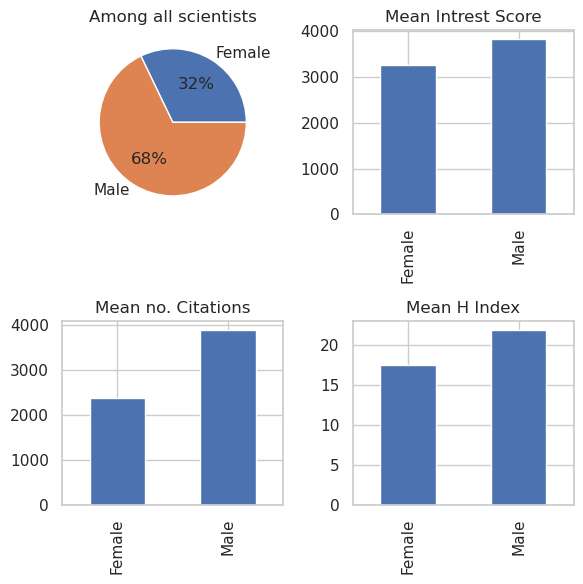

In [37]:
fig = plt.figure(figsize=(6,6))
ax_1 = plt.subplot(221); df.groupby(by=["Gender"]).count()['Institute'].plot(ylabel='', kind ='pie' , ax=ax_1 , title = 'Among all scientists', autopct='%1.f%%'); #pie chart count
ax_2 = plt.subplot(222); df.groupby(by=["Gender"]).mean()['Interest score'].plot(xlabel='',kind ='bar' , ax=ax_2,title='Mean Intrest Score'); #mean intrest value
ax_3 = plt.subplot(223); df.groupby(by=["Gender"]).mean()['Citations'].plot(xlabel='',kind ='bar' , ax=ax_3 , title='Mean no. Citations');#mean 
ax_4 = plt.subplot(224); df.groupby(by=["Gender"]).mean()['h index'].plot(xlabel='', kind ='bar' , ax=ax_4 , title='Mean H Index');#mean
fig.tight_layout()

We witness that women are still underrepresented in many scientific fields in academia, especially in higher positions. This is due to factors such as implicit bias, gender stereotypes, and lack of support. Academic institutions and the scientific community need to work together to promote diversity, provide equal opportunities, and encourage young women to pursue science careers.

## <a class="anchor" id="Interimconclusions"></a> <span style="color:black"> Interim conclusions </span>

In [38]:
df.corr()["h index"].sort_values()

Shanghai_ranking   -0.301562
PISA rank          -0.289788
Position rank       0.053868
HDI score           0.173123
GDP (Millions $)    0.245993
Recommendations     0.296905
Reads               0.382567
Interest score      0.643960
Citations           0.791692
Publications        0.798109
h index             1.000000
Name: h index, dtype: float64

__In order to echive a higher corollations, We shall try removing:__
* scientists whom hadn't decladered their level of degree or position in their institue.
* scientists whos publiction and citation are 0.

In [39]:
alternate_df = df[df['Position rank']>0]
alternate_df.corr()["h index"].sort_values()

Shanghai_ranking   -0.270394
PISA rank          -0.269722
Position rank       0.133634
HDI score           0.168352
GDP (Millions $)    0.216664
Recommendations     0.294765
Reads               0.375411
Interest score      0.621723
Publications        0.798140
Citations           0.799598
h index             1.000000
Name: h index, dtype: float64

We percive that the position rank has a very weak impact upon the h index.  
After removing all undecladered degree's scientists, and undergraduats, the improvement is from 0.047010 to 0.133629.  
We decide not removing those rows.

In [40]:
alternate_df = df[df['Publications']>0]
alternate_df = alternate_df[alternate_df['Citations']>0]
alternate_df.corr()["h index"].sort_values()

Shanghai_ranking   -0.295102
PISA rank          -0.286836
Position rank       0.034476
HDI score           0.175393
GDP (Millions $)    0.236937
Recommendations     0.295304
Reads               0.380229
Interest score      0.638217
Citations           0.793754
Publications        0.795960
h index             1.000000
Name: h index, dtype: float64

Again, removing scientists whom have no Publications and Citations have very weak improvement in the correlation with the h index.  
Interest score is dependent on both publications and citations, reads on the other hand is independent. we would show in 4D graph the impact of these three parameters on the h index:

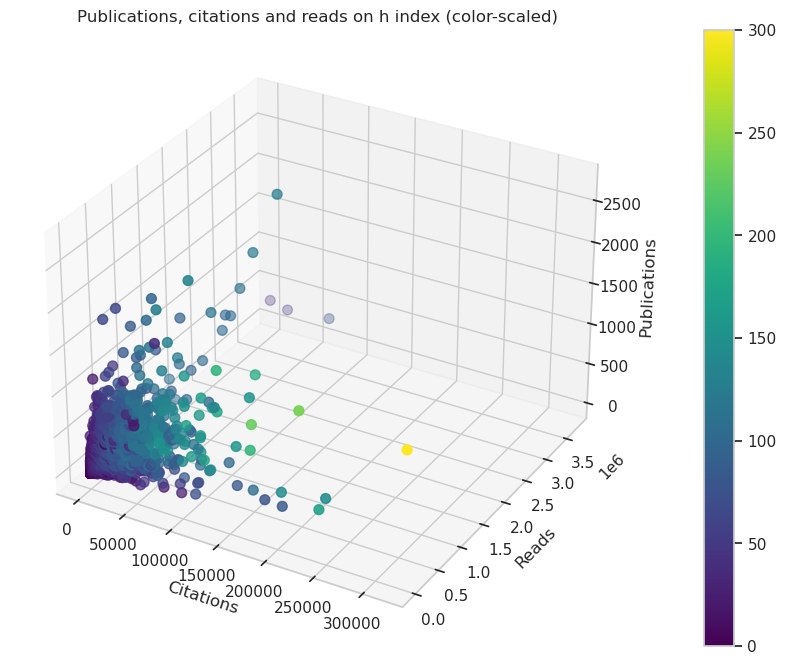

In [41]:
fig = plt.figure(figsize=(20,8))

ax = fig.add_subplot(111, projection='3d', xlabel='Citations',
                     ylabel='Reads', zlabel='Publications')

z = df['Publications'].tolist()
x = df['Citations'].tolist()
y = df['Reads'].tolist()
c = df['h index'].tolist()

img = ax.scatter(x, y, z, c=c, cmap='viridis', s=50)
fig.colorbar(img)
plt.title('Publications, citations and reads on h index (color-scaled)')
plt.show()

<Figure size 640x480 with 0 Axes>

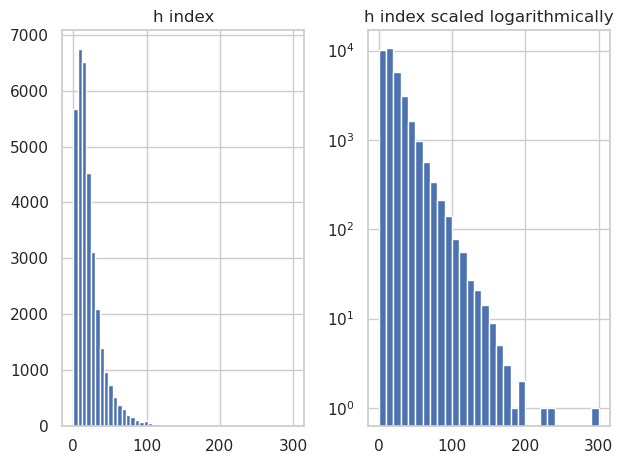

In [72]:
fig = plt.figure();

fig, (ax1, ax2) = plt.subplots(1, 2);

ax1.hist(y, bins=50);
ax1.set_title("h index");

ax2.hist(y, bins=30);
plt.yscale('log');
ax2.set_title("h index scaled logarithmically");
fig.tight_layout()

After scaling the h index logarithmically, the decreasion apear to be linear. It means that the higher the h index is the amount of people decreased exponnetially.

$$e^{-x} \ \ \text{behaviour in left, and}\ \ \  log(e^{-x}) = -x\ \ \ \text{in right}$$

# <a class="anchor" id="Machinelearningmodels"></a> <span style="color:black"> Machine learning models </span>
Now we will remove all columns which irrelevant for the model:
* Gende -> covert to Female to 0 and Male to 1
* remove 'Full name'
* remove 'Position'
* remove 'Nation'
* remove 'Disciplines'
* remove 'Depratment'
* remove 'Institute'
* remove 'Top cited research'

## <a class="anchor" id="Preparations"></a> <span style="color:black"> Preparations </span>

In [43]:
import sklearn
model_df = df.drop(['Full name', 'Institute', 'Position', 'Nation', 
                    'Disciplines', 'Depratment', 'Top cited research'], axis=1)

le = sklearn.preprocessing.LabelEncoder()
model_df['Gender'] = le.fit_transform(model_df.Gender) 

# adding an average h index of a nation
Average_h_index = {"Israel":15.593223, "United States":26.894334, "Great Britain":32.698174, 
                   "France":10.220755, "Switzerland":27.167742, "Canada":30.270510, 
                   "Japan":24.569689,"China":25.345938,"Chile":11.978551,"Brazil":18.869754,
                   "Colombia":7.764674,"Mexico":19.434924,"Argentina":13.673216}

def country_to_average_h_index(country):
    avg = []
    for x in country:
        avg.append(Average_h_index[x])
    return avg

model_df['Average h index'] = country_to_average_h_index(df['Nation'])

model_df.to_csv('DataFrame_for_model.csv', index=False)

loading the dataset

In [44]:
model_df = load_dataset('DataFrame_for_model.csv')

try:
    df.drop(["Unnamed: 0"], axis=1, inplace=True)
except:
     print ("")

We will remove all features that are directly dependent on others
Shangai ranking is given to an institution and GDP, HDI are given to a state
and remove all the columns with strings

In [45]:
df_for_ML = df_after_data_cleansing.drop(['Full name','Top cited research', 'Position', 'Disciplines', 'Depratment' ]
             ,axis=1).copy()

In [46]:
#adding Dr. Jonathan Schler to the test dataframe for the demo at the end
jonathan_schler = pd.Series({
                             'Gender':'Male' ,
                             'Nation':'Israel',
                             'Institute':'Bar Illan University',
                             'Shanghai_ranking':301,
                             'Publications':41 ,
                             'Citations':3689,
                             'Recommendations':5,
                             'Interest score':2067,
                             'Reads':31027 , 
                             'PISA rank':43, 
                             'GDP (Millions $)':488527,
                             'HDI score':0.919,
                             'Position rank':3 })


Extracting the feature vector `h index` and splitting into Test and Train sets

In [47]:
from sklearn.model_selection import train_test_split
Xl , yl= df_for_ML.drop('h index',axis=1) , df_for_ML['h index']
#adding Jonathan Schler to the dataset
Xl.loc[-1] = jonathan_schler
yl.loc[-1] = 20
X_trainl, X_testl, y_trainl, y_testl = train_test_split(Xl,yl , random_state=42)
X_trainl.head()

Gender         Nation                           Institute  \
18526    Male  Great Britain             University of Cambridge   
7295     Male  United States                  Cornell University   
21847    Male         France                 Ecole-Polytechnique   
2210   Female  United States                     Yale-University   
10315    Male         Israel  Ben-Gurion-University-of-the-Negev   

       Shanghai_ranking  Publications  Citations  Recommendations  \
18526                 4           102       4193              235   
7295                 12            25       1131               11   
21847               301           114       1684               33   
2210                 11            69       1359               10   
10315               401            26        191               15   

       Interest score  Reads  PISA rank  GDP (Millions $)  HDI score  \
18526            3005  96408         15           3131378      0.929   
7295             6058  10662         19          23315081      0.921   
21847            9018  28526         25           2957880      0.903   
2210             7669  11383         19          23315081      0.921   
10315             999   1135         43            488527      0.919   

       Position rank  
18526              3  
7295               3  
21847              2  
2210               3  
10315              3

## <a class="anchor" id="Differentmachinelearningalgorithms"></a> <span style="color:black"> Different machine learning algorithms </span>

### <a class="anchor" id="LinearRegression"></a> <span style="color:black"> Linear Regression </span>

When working with Linear Regression we first need to scale our feature , we will use `MinMaxScaler`

In [48]:
X_train_numeric =X_trainl._get_numeric_data().drop(['Position rank'],axis=1)
print(X_train_numeric.columns)
X_numeric_cols = X_train_numeric.columns
X_test_numeric  = X_testl[X_numeric_cols].copy()

Index(['Shanghai_ranking', 'Publications', 'Citations', 'Recommendations',
       'Interest score', 'Reads', 'PISA rank', 'GDP (Millions $)',
       'HDI score'],
      dtype='object')


In [49]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_numeric), columns=X_numeric_cols, index=X_trainl.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test_numeric), columns=X_numeric_cols, index=X_testl.index)
X_train_scaled.head()

Shanghai_ranking  Publications  Citations  Recommendations  \
18526           0.00375      0.037294   0.017560         0.017936   
7295            0.01375      0.009141   0.004737         0.000840   
21847           0.37500      0.041682   0.007052         0.002519   
2210            0.01250      0.025229   0.005691         0.000763   
10315           0.50000      0.009506   0.000800         0.001145   

       Interest score     Reads  PISA rank  GDP (Millions $)  HDI score  
18526        0.025388  0.025873    0.21875          0.122471   0.842857  
7295         0.051182  0.002861    0.28125          1.000000   0.804762  
21847        0.076190  0.007656    0.37500          0.114928   0.719048  
2210         0.064793  0.003055    0.28125          1.000000   0.804762  
10315        0.008440  0.000305    0.65625          0.007568   0.795238

In [50]:
##FOR DEMO -  Dr. Schler feature vector scaled 
Xl.iloc[-1]

Gender                              Male
Nation                            Israel
Institute           Bar Illan University
Shanghai_ranking                     301
Publications                          41
Citations                           3689
Recommendations                        5
Interest score                      2067
Reads                              31027
PISA rank                             43
GDP (Millions $)                  488527
HDI score                          0.919
Position rank                          3
Name: -1, dtype: object

In [51]:
clf = sklearn.linear_model.LinearRegression()
clf.fit(X_train_scaled,y_trainl)

LinearRegression()

Let's evaluate the performance of out model,


First, we'll take a look in the $SSE$ and $R^2$ scores.



In [52]:
from sklearn.metrics import mean_squared_error, r2_score
y_predictl = clf.predict(X_test_scaled)
print(f"SSE = {mean_squared_error(y_testl , np.floor(y_predictl))}  " )
print(f"R2 = {r2_score(y_testl , np.floor(y_predictl))}")

SSE = 77.77926699086704  
R2 = 0.7826563289230114


### <a class="anchor" id="Improvingattempts"></a> <span style="color:black"> Improving attempts </span>

#### reducing columns

In [53]:
X_train_numeric_new =X_trainl._get_numeric_data().drop(['Position rank','GDP (Millions $)','HDI score','Shanghai_ranking','Reads','PISA rank'],axis=1)
print(X_train_numeric_new.columns)
X_numeric_cols_new = X_train_numeric_new.columns
X_test_numeric_new  = X_testl[X_numeric_cols_new].copy()
X_train_scaled_new = pd.DataFrame(scaler.fit_transform(X_train_numeric_new), columns=X_numeric_cols_new, index=X_trainl.index)
X_test_scaled_new  = pd.DataFrame(scaler.transform(X_test_numeric_new), columns=X_numeric_cols_new, index=X_testl.index)
X_train_scaled_new.head()

Index(['Publications', 'Citations', 'Recommendations', 'Interest score'], dtype='object')


Publications  Citations  Recommendations  Interest score
18526      0.037294   0.017560         0.017936        0.025388
7295       0.009141   0.004737         0.000840        0.051182
21847      0.041682   0.007052         0.002519        0.076190
2210       0.025229   0.005691         0.000763        0.064793
10315      0.009506   0.000800         0.001145        0.008440

In [54]:
clf_new = sklearn.linear_model.LinearRegression()
clf_new.fit(X_train_scaled_new,y_trainl)

LinearRegression()

In [55]:
y_predictl_new = clf_new.predict(X_test_scaled.drop(['GDP (Millions $)',
                                                     'HDI score',
                                                     'Shanghai_ranking',
                                                     'Reads',
                                                     'PISA rank'],axis=1))

print(f"SSE = {mean_squared_error(y_testl , np.floor(y_predictl_new))}  " )
print(f"R2 = {r2_score(y_testl , np.floor(y_predictl_new))}")

SSE = 84.91804056458308  
R2 = 0.7627079890179692


#### PCA


In [56]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_numeric)
X_test_pca = pca.fit_transform(X_test_numeric)
X_pca_train_scaled = scaler.fit_transform(X_train_pca)
X_pca_test_scaled  = scaler.transform(X_test_pca)
X_pca_train_scaled

array([[1.22468017e-01, 2.70964071e-02, 4.61078565e-01, 3.05014256e-01],
       [9.99966551e-01, 2.92236972e-03, 4.63185396e-01, 3.48512198e-01],
       [1.14924484e-01, 8.91882107e-03, 4.71238739e-01, 3.76149163e-01],
       ...,
       [7.56769308e-03, 6.65245864e-03, 4.67337072e-01, 3.41693847e-01],
       [9.99966467e-01, 9.94378470e-04, 4.58407391e-01, 3.05618076e-01],
       [9.99966586e-01, 3.50022784e-03, 4.67312446e-01, 3.84817307e-01]])

In [57]:
clf_pca = sklearn.linear_model.LinearRegression()
clf_pca.fit(X_pca_train_scaled,y_trainl)

LinearRegression()

In [58]:
y_pca_predict = clf_pca.predict(pca.fit_transform(X_test_scaled))
print(f"SSE = {mean_squared_error(y_testl , np.floor(y_pca_predict))}  " )
print(f"R2 = {r2_score(y_testl , np.floor(y_pca_predict))}")

SSE = 143937.80963112324  
R2 = -401.21479530891526


## <a class="anchor" id="RandomForest"></a> <span style="color:black"> Random Forest </span>

The algorithm builds a large number of decision trees, each trained on a random subset of the training data and a random subset of the features. The final prediction is then made by averaging or voting the predictions of the individual trees. This technique helps to reduce overfitting and improve the accuracy of the model. 

### Training

First , let's make little adjustments to our dataframe. first we should seperate the categorial columns to have a binary representation of inclusion in each category. we can easily do so with `pd.get_dummies`

In [59]:
X , y= df_for_ML.drop('h index',axis=1) , df_for_ML['h index']
categories =  ['Gender', 'Position rank', 'Institute' ,'Nation']
X = pd.get_dummies(X, columns=categories)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [60]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 10)
forest.fit(X_train , y_train)


RandomForestClassifier(n_estimators=10)

In [61]:
y_predict = forest.predict(X_test)
y_predict_train = forest.predict(X_train)

### Evaluation of the model and improvements 

In [62]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Accuracy on test data:",metrics.accuracy_score(y_true = y_test, y_pred= y_predict))
print("Accuracy on training data:",metrics.accuracy_score(y_true = y_train, y_pred= y_predict_train))

Accuracy on test data: 0.18230340410390228
Accuracy on training data: 0.9888493475682087


The model is overfitted to the training set and does not yield good result when tested against the test dataset\
to avoid so first lets get rid of some features

In [63]:
#Removed features and prepering for training
df_randforst = df_for_ML.drop(['Nation' ,'Shanghai_ranking','Institute','PISA rank'], axis=1)

y= df['h index']
target_col_name = 'h index'
categories =  ['Gender']
X = pd.get_dummies(df_randforst, columns=categories)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [70]:
X_train.head()

Publications  Citations  Recommendations  Interest score  Reads  \
1345             41      11693               66            7127  81610   
10054            39       1063               48            6092   5726   
3949             70        883               19            5092  18312   
3362             89       3353               12            2025  55271   
29500           114        634               12            3039   6068   

       h index  GDP (Millions $)  HDI score  Position rank  Gender_Female  \
1345        23          23315081      0.921              4              1   
10054       16            488527      0.919              3              0   
3949        18          23315081      0.921              3              0   
3362        25          23315081      0.921              3              0   
29500       13           1608981      0.754              0              1   

       Gender_Male  
1345             0  
10054            1  
3949             1  
3362             1  
29500            0

In [64]:
forest = RandomForestClassifier(n_estimators = 10)
forest.fit(X_train , y_train)
y_predict = forest.predict(X_test)
y_predict_train = forest.predict(X_train)

In [65]:
print("Accuracy on test data:",metrics.accuracy_score(y_true = y_test, y_pred= y_predict))
print("Accuracy on training data:",metrics.accuracy_score(y_true = y_train, y_pred= y_predict_train))


Accuracy on test data: 0.8816273277191318
Accuracy on training data: 0.999288256227758


The results are vastly improved. we may be able to improve it further by training our model with different parameters.


In [66]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
parameters = {
    'bootstrap':[True],
    'n_estimators':[10, 20 ,50],
    'random_state':[0],
    'max_features':['sqrt', 'log2', 'auto']
}
best_forest = GridSearchCV(RandomForestClassifier(), parameters, scoring=make_scorer(metrics.accuracy_score, greater_is_better=True))

In [67]:
best_forest.fit(X_train , y_train)

y_predict = best_forest.predict(X_test)
y_predict_train = best_forest.predict(X_train)

In [68]:
print("Accuracy on test data:",metrics.accuracy_score(y_true = y_test, y_pred= y_predict))
print("Accuracy on training data:",metrics.accuracy_score(y_true = y_train, y_pred= y_predict_train))
print("SSE on test data:", mean_squared_error(y_test, y_predict ))
print("R2 on test data:", r2_score(y_test, y_predict ))


Accuracy on test data: 0.932392361522951
Accuracy on training data: 1.0
SSE on test data: 5.456648084450243
R2 on test data: 0.9851317800488011


The model is much improved and gives good fitting for both the training and test set

## <a class="anchor" id="Demonstration"></a> <span style="color:black"> Demonstration </span>

In [69]:
print("Dr. Schler's actual h index: " ,yl.iloc[-1])
print("predicted h index (Linear Regression): ",np.round(y_predictl[-1]))
print("predicted h index (Random Forest) ",y_predict[-1])

Dr. Schler's actual h index:  20
predicted h index (Linear Regression):  22.0
predicted h index (Random Forest)  26


# <a class="anchor" id="Conclusions"></a> <span style="color:black"> Conclusions </span>

Whilst there are some features which are moderately correlated to the h index, a linear regression model, even with a medium accuracy, appear to be the optimal option available that doesn’t uses a neural network. 

We could predict a close h index of a scientists to his actual, relying of his other features.

Additionally, we saw that there are gaps and biases among genders, and nations that suffer from poor education to nations with advanced education system, in producing successful scientist.

